This is a script to detect human poses in images, track them and evaluate if they enter or leave a bus. Based on the official google colab tutorial from Detectron2.

In [1]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9")   # please manually install torch 1.9 if Colab changes its default version

1.9.0 True


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

from Visualization import VisualizeData, VisualizeCase, ShowImages
from Detection import GetPredictor, Tracker, SaveOutput
from EvaluateResults import Classify
from MatchBusStops import MatchStops

In [3]:
# Set the jupyter notebook width to full available width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

In [5]:
# define paths to different datasets for debugging
path_to_datasets = "../data/extracted_images/"
path_sunny = path_to_datasets + "filtered/sunny_2021_03_23_14_33_cam5_filtered/"
path_cloudy = path_to_datasets + "filtered/cloudy_2021_04_09_16_02_cam5_filtered/"
path_cam_5 = path_to_datasets + "bus_2021-02-05-18-13-55_21/cam5/"
path_bw = path_to_datasets + "bus_2021-02-08-18-52-30_16/cam5" # 1 exit at ca 1869
path_1 = path_to_datasets + "bus_2021-02-05-14-51-40_1/cam5" # 1 coming from front of bus entering at 1683
path_2 = path_to_datasets + "bus_2021-02-12-08-52-38_15/cam5" # 2 * 1 left
path_2b = path_to_datasets + "bus_2021-02-12-08-52-38_15_stops/cam5" # 2 * 1 left
path_3 = path_to_datasets + "bus_2021-02-11-18-57-31_21/cam5" # bus driver leaves and enters
path_4 = path_to_datasets + "bus_2021-02-05-14-41-00_0/cam5"
path_5 = path_to_datasets + "bus_2021-02-12-08_stops/cam5"
path_6 = path_to_datasets + "bus_2021-02-25_active_stops"
path_7 = path_to_datasets + "bus_2021-02-12-08_active_stops"
path_8 = path_to_datasets + "bus_2021-02-25/cam5"
path_9 = path_to_datasets + "bus_2021-02-26/cam5"
path_10 = path_to_datasets + "bus_2021-03-01-11/cam5"
path_11 = path_to_datasets + "bus_2021-02-12/cam5"
path_12 = path_to_datasets + "bus_2021-03-03-07/cam5"
path_13 = path_to_datasets + "bus_2021-07-30-12-55/cam5"
path_14 = path_to_datasets + "bus_2021-08-02-12-57/cam5"
path_15 = path_to_datasets + "bus_2021-07-30-17-11/cam5"
path_16 = path_to_datasets + "bus_2021-08-02-10-25/cam5"
path_17 = path_to_datasets + "bus_2021-08-02-12-57/cam5"
path_18 = path_to_datasets + "SampleData/cam5"
used_data_path = path_18

# define and create the output directories
output_dir = "../results/DetectedBusStops/" + used_data_path.split('/')[-2]
output_dir_officials = "../results/DetectedOfficialBusStops/" + used_data_path.split('/')[-2]
output_dir_unofficials = "../results/DetectedUnofficialBusStops/" + used_data_path.split('/')[-2]
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_dir_officials, exist_ok=True)
os.makedirs(output_dir_unofficials, exist_ok=True)

In [6]:
# read in the names of the images in the dataset
imgs = sorted([join(used_data_path, f) for f in listdir(used_data_path) if isfile(join(used_data_path, f)) and f[-4:] == ".jpg"])
complete_dataset = [{"file_name" : f} for f in imgs]
print("Length of dataset:", len(complete_dataset))
# Print the first 10 entries
print(complete_dataset[:10])

Length of dataset: 85
[{'file_name': '../data/extracted_images/SampleData/cam5/camera5_1627665684_067216832.jpg'}, {'file_name': '../data/extracted_images/SampleData/cam5/camera5_1627665684_265972599.jpg'}, {'file_name': '../data/extracted_images/SampleData/cam5/camera5_1627665684_472652448.jpg'}, {'file_name': '../data/extracted_images/SampleData/cam5/camera5_1627665684_665974611.jpg'}, {'file_name': '../data/extracted_images/SampleData/cam5/camera5_1627665684_865093697.jpg'}, {'file_name': '../data/extracted_images/SampleData/cam5/camera5_1627665685_065447598.jpg'}, {'file_name': '../data/extracted_images/SampleData/cam5/camera5_1627665685_266083567.jpg'}, {'file_name': '../data/extracted_images/SampleData/cam5/camera5_1627665685_465270028.jpg'}, {'file_name': '../data/extracted_images/SampleData/cam5/camera5_1627665685_665745331.jpg'}, {'file_name': '../data/extracted_images/SampleData/cam5/camera5_1627665685_867868726.jpg'}]


In [7]:
# Visualize some results
%matplotlib inline

In [8]:
# This loads the standard detectron2 predictor
predictor = GetPredictor()

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


Analyzing dataset:  ../data/extracted_images/SampleData/cam5
+1 entered -  0  img  ../data/extracted_images/SampleData/cam5/camera5_1627665686_867068122.jpg
img:  ../data/extracted_images/SampleData/cam5/camera5_1627665686_867068122.jpg
Entered:  1
Left:  0
Unsure:  0


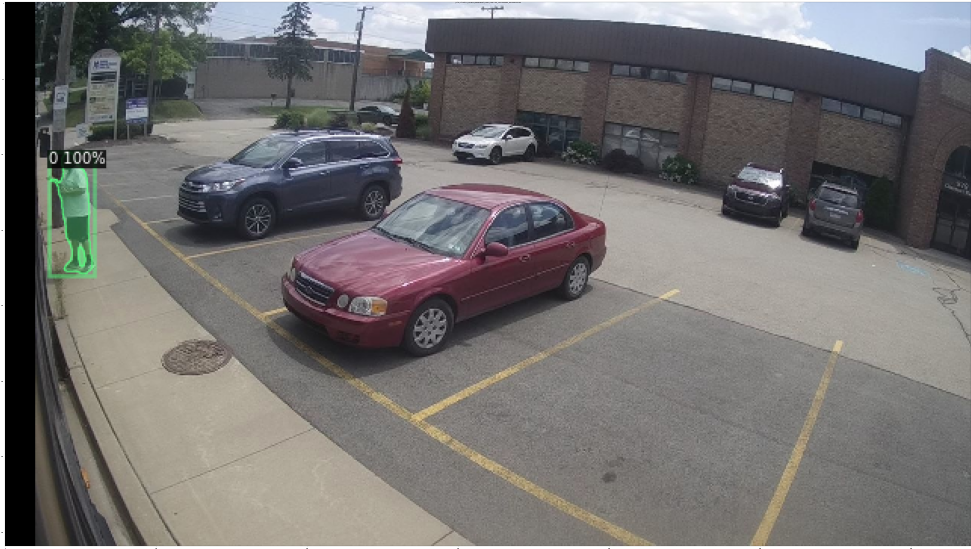

In [15]:
print("Analyzing dataset: ", used_data_path)
tracker = Tracker()
tracker.Init()

# run the detector over the complete dataset
json_data = tracker.DetectInDataset(complete_dataset, None, predictor, len(complete_dataset), start=0, step=1, slideshow=False, deleteAfter=1, view="near")
# run the detector only over a part of the dataset
# json_data = tracker.DetectInDataset(complete_dataset, None, predictor, 50, start=6220, step=1, slideshow=False, deleteAfter=1, view="all")

print("Entered: ", json_data["Entered"])
print("Left: ", json_data["Left"])
print("Unsure: ", json_data["Unsure"])

In [16]:
# Outcomment if the output should be saved
# SaveOutput(json_data, used_data_path, 'output', overwrite=True)

Saving file  ../data/extracted_images/SampleData/cam5output.txt


In [9]:
# Evaluate the detection. Uses the saved output
true_positives, false_positives, false_negatives, true_positives_el, false_positives_el, predictedStops = Classify(used_data_path, complete_dataset)

../data/extracted_images/SampleData/cam5/camera5_1627665686_867068122.jpg  vs  data/bus_data/bus_2021-07-30-12-55/cam5/camera5_1627665689_066162007.jpg
True positives:  1
False positives:  0
False negatives:  0
True negatives:  84
True classifications:  1
False classifications:  0
Saving file  ../data/extracted_images/SampleData/cam5results.txt


In [18]:
# Show the true positives
# ShowImages(complete_dataset, json_data, true_positives)

In [19]:
# Show the false positives
ShowImages(complete_dataset, json_data, false_positives)

In [20]:
# Show the false negatives
# ShowImages(complete_dataset, json_data, false_negatives)

In [21]:
# Show the true classifications
# ShowImages(complete_dataset, json_data, true_positives_el)

In [22]:
# Show the false classifications
# ShowImages(complete_dataset, json_data, false_positives_el)

In [23]:
# VisualizeCase(complete_dataset, predictor, 3, true_positives, 20, 50)

In [24]:
# print(false_positives)
# print(false_negatives)

In [12]:
# Compare the detected stops from the output file to the official stops listed in the gtfs data and store images into official and unofficial busstop categories
MatchStops(predictedStops, output_dir, output_dir_officials, output_dir_unofficials)

Stop:  ../data/extracted_images/SampleData/cam5/camera5_1627665686_867068122.jpg
243.3699874043297  -  ../data/extracted_images/SampleData/cam5/camera5_1627665686_867068122.jpg  -  Washington High School (Hall Ave.)  -  [ 40.17136667 -80.25383333]  -  [40.1733033603669, -80.2528055337295]
